<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

### Self Attention

- Goal is to transform a $(T, D)$ input matrix into a $(T, D)$ matrix with the transformation described below.
  
  Create 3 matrices, $W^Q$, $W^K$, $W^V$, each of shape $(D, D_K)$
  
  $X * W^Q = Q$
  
  $X * W^K = K$
  
  $X * W^V = V$
  
  Now, $QK^T$ has shape $(T, T)$. This is referred to as the attention matrix.

  The full self attention operator can be described as $Softmax(\frac{Q*K^T}{\sqrt{D_K}}) * X$
- The division with $\sqrt{D_K}$ allows for numerical stability and softmax operator provides a probabilistic interprettation for each row of the attention matrix. Row $i$ of attention of matrix can be interpretted as weighted contributions from context tokens to token $i$.

- For LLM like tasks where it is useful to enforce directionationlity, future should not influence the past, the attention matrix can be made an lower diagonal matrix.



In [2]:
x = torch.tensor([
    [0.4, 0.4, 0.1],
    [0.9, 1.2, 0.1],
    [-0.2, -0.8, 0.5],
    [0.3, 0.6, 0.8]
])

# shape of input is (T, D) where T is number of tokens and D is dimensionality of token vector

x.shape


torch.Size([4, 3])

In [ ]:
T = x.shape[0]
D = x.shape[1]
H = 2

W_Q = torch.rand(D, H)
W_K = torch.rand(D, H)
W_V = torch.rand(D, H)


Q = x @ W_Q
K = x @ W_K
V = x @ W_V

self_attention_matrix = nn.Softmax()(Q @ K.T)
self_attended_input = self_attention_matrix @ V
self_attended_input.shape

torch.Size([4, 2])

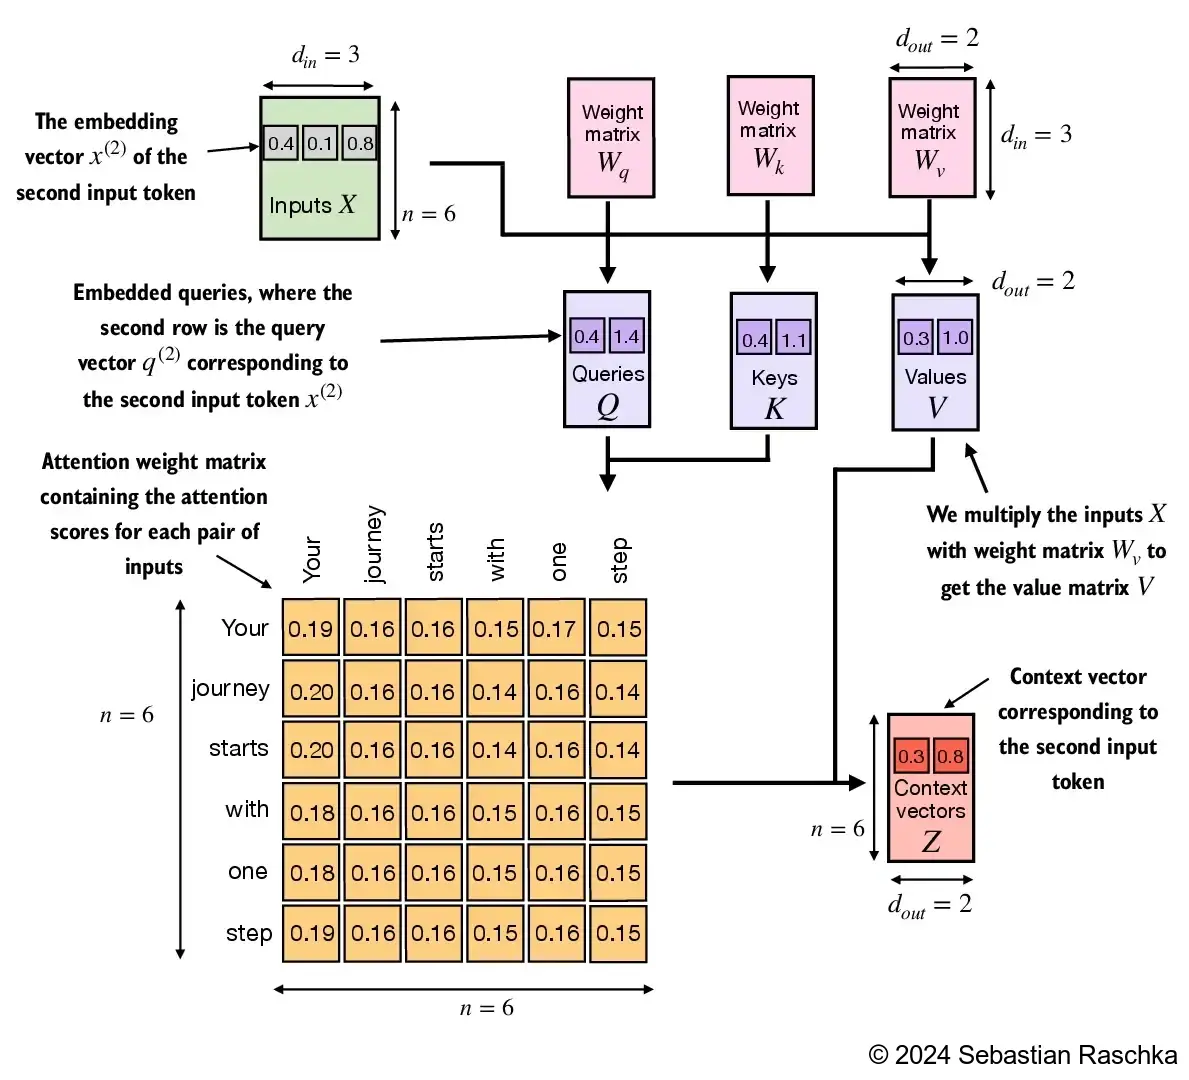

In [92]:
class SelfAttentionV1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_Q = nn.Parameter(torch.rand(d_in, d_out))
        self.W_K = nn.Parameter(torch.rand(d_in, d_out))
        self.W_V = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):

        Q = x @ self.W_Q
        K = x @ self.W_K
        V = x @ self.W_V

        sqrt_dk = torch.sqrt(torch.tensor(K.shape[2]))

        self_attention_matrix = torch.softmax(Q @ torch.transpose(K, 1, 2) / sqrt_dk, dim=-1) #(n, T, T) matrix

        self_attended_input = self_attention_matrix @ V # (n, T, d_out)

        return self_attended_input

X = torch.rand((1, 3, 4))
d_in = X.shape[2]
d_out = 2

self_attention = SelfAttentionV1(d_in, d_out)
self_attended_input = self_attention(X)
self_attended_input.shape


torch.Size([1, 3, 2])

- We can just use linear layers in pytorch

In [60]:
class SelfAttentionV2(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_Q = nn.Linear(d_in, d_out)
        self.W_K = nn.Linear(d_in, d_out)
        self.W_V = nn.Linear(d_in, d_out)

    def forward(self, x):

        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        sqrt_dk = torch.sqrt(torch.tensor(K.shape[2]))

        self_attention_matrix = torch.softmax(Q @ torch.transpose(K, 1, 2) / sqrt_dk, dim=-1) #(n, T, T) matrix

        # check that all rows of self attention matrix sum to 1

        assert(torch.allclose(self_attention_matrix.sum(dim=-1), torch.ones_like(self_attention_matrix.sum(dim=-1))))


        self_attended_input = self_attention_matrix @ V # (n, T, d_out)

        return self_attended_input

X = torch.rand((1, 3, 4), requires_grad=True)
d_in = X.shape[2]
d_out = 2

self_attention = SelfAttentionV2(d_in, d_out)
self_attended_input = self_attention(X)
self_attended_input.shape


torch.Size([1, 3, 2])

### Let's make the attention mask causal
  - The word step depends on all words that came before it.
  - $x_i$ depends on all $x_j$ such that $i >= j$. So $x[i, j] = 0$ if $i < j$

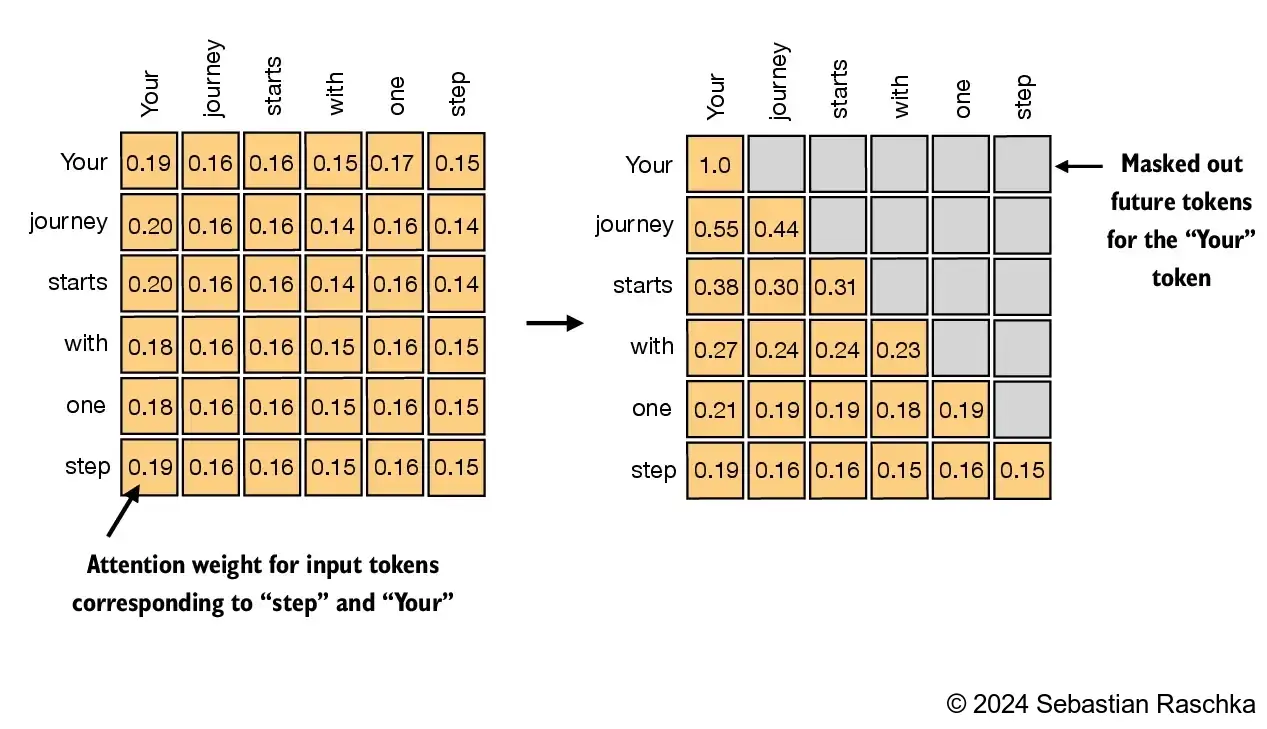

#### Exploring tril
- Main diagonal is $i==j$, so a[i, i]. Setting diagonal to 1, chooses the first diagonal above main diagonal. $i+1==j$, so $a[i, i+1]$. Setting diagonal to -1, chooses first diagonal below main diagonal, so $a[i, i-1]$

In [46]:
a = torch.randn((5, 5))
print(f"a is  \n {a}")

print(f"tril of a is \n", torch.tril(a))

print(f"tril 1st positive of a is \n", torch.tril(a, diagonal=1))

a is  
 tensor([[-0.9107,  1.2784,  0.7568, -0.4703, -0.3434],
        [-0.2583, -0.2429, -0.1811,  0.9357, -0.3146],
        [-0.2246,  0.4379,  1.0647,  1.2722, -1.5027],
        [ 0.1338,  1.0676, -1.7268, -0.3351, -0.4977],
        [ 0.3165,  0.6433,  0.2257,  1.1892, -0.1418]])
tril of a is 
 tensor([[-0.9107,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2583, -0.2429,  0.0000,  0.0000,  0.0000],
        [-0.2246,  0.4379,  1.0647,  0.0000,  0.0000],
        [ 0.1338,  1.0676, -1.7268, -0.3351,  0.0000],
        [ 0.3165,  0.6433,  0.2257,  1.1892, -0.1418]])
tril 1st positive of a is 
 tensor([[-0.9107,  1.2784,  0.0000,  0.0000,  0.0000],
        [-0.2583, -0.2429, -0.1811,  0.0000,  0.0000],
        [-0.2246,  0.4379,  1.0647,  1.2722,  0.0000],
        [ 0.1338,  1.0676, -1.7268, -0.3351, -0.4977],
        [ 0.3165,  0.6433,  0.2257,  1.1892, -0.1418]])


#### Set upper diagonal entries to 0 with triu, softmax

In [47]:
mask = torch.triu(torch.ones_like(a, dtype=bool), diagonal=1)
a[mask] = -float('inf')
print(a)

print(torch.softmax(a, dim=1))

tensor([[-0.9107,    -inf,    -inf,    -inf,    -inf],
        [-0.2583, -0.2429,    -inf,    -inf,    -inf],
        [-0.2246,  0.4379,  1.0647,    -inf,    -inf],
        [ 0.1338,  1.0676, -1.7268, -0.3351,    -inf],
        [ 0.3165,  0.6433,  0.2257,  1.1892, -0.1418]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4961, 0.5039, 0.0000, 0.0000, 0.0000],
        [0.1522, 0.2952, 0.5525, 0.0000, 0.0000],
        [0.2312, 0.5882, 0.0360, 0.1447, 0.0000],
        [0.1581, 0.2192, 0.1444, 0.3784, 0.1000]])


#### Causal self attention

In [67]:
class SelfAttentionV3(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_Q = nn.Linear(d_in, d_out)
        self.W_K = nn.Linear(d_in, d_out)
        self.W_V = nn.Linear(d_in, d_out)

    def forward(self, x):

        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        sqrt_dk = torch.sqrt(torch.tensor(K.shape[2]))

        self_attention_scores = Q @ torch.transpose(K, 1, 2) / sqrt_dk
        mask = torch.triu(torch.ones_like(self_attention_scores, dtype=bool), diagonal=1)
        self_attention_scores[mask] = -float('inf')
        self_attention_matrix = torch.softmax(self_attention_scores, dim=-1) #(n, T, T) matrix

        # check that all rows of self attention matrix sum to 1

        assert(torch.allclose(self_attention_matrix.sum(dim=-1), torch.ones_like(self_attention_matrix.sum(dim=-1))))

        # check that self attention matrix is lower triangular
        assert(torch.allclose(self_attention_matrix, torch.tril(self_attention_matrix, diagonal=1)))

        self_attended_input = self_attention_matrix @ V # (n, T, d_out)

        return self_attended_input

X = torch.rand((1, 3, 4), requires_grad=True)
d_in = X.shape[2]
d_out = 2

self_attention = SelfAttentionV3(d_in, d_out)
self_attended_input = self_attention(X)
self_attended_input.shape


torch.Size([1, 3, 2])

### Causal self attention with drop out

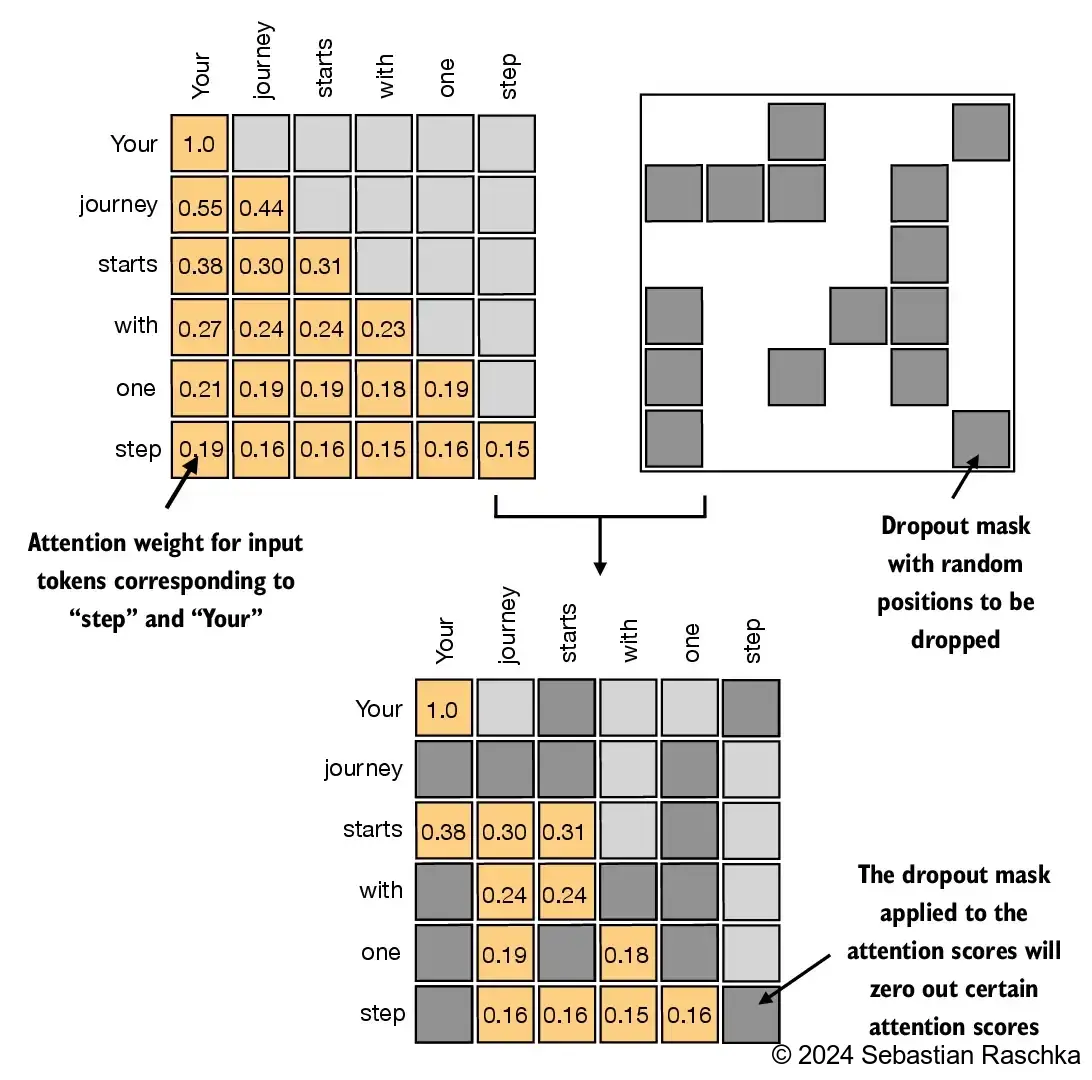

In [73]:
a = torch.randn((6, 6))

print(f"a is \n {a}")

da = nn.Dropout(p=0.5)(a)

print(f"drop out of a is \n {da}")


a is 
 tensor([[-0.6124,  0.2745,  1.0812,  0.9880,  0.0972,  3.4749],
        [-0.7707,  0.2175, -0.8165, -0.7598,  2.4266, -0.7358],
        [-0.6114, -0.0986,  1.6539, -1.4572,  0.5491,  0.9228],
        [-1.7003, -0.6913,  0.3151,  0.2096, -1.7041,  1.3842],
        [-0.8420, -0.5028, -0.7852, -1.8795,  0.3751,  1.2718],
        [-2.1340, -0.0980, -0.7710, -1.6350, -0.7199, -1.8089]])
drop out of a is 
 tensor([[-0.0000,  0.5491,  2.1625,  1.9759,  0.1945,  6.9498],
        [-0.0000,  0.0000, -1.6330, -0.0000,  4.8532, -1.4716],
        [-1.2227, -0.1971,  3.3078, -2.9143,  0.0000,  0.0000],
        [-0.0000, -1.3826,  0.6301,  0.4191, -0.0000,  0.0000],
        [-0.0000, -0.0000, -1.5703, -3.7590,  0.0000,  0.0000],
        [-0.0000, -0.1961, -1.5419, -3.2699, -1.4398, -0.0000]])


In [79]:
class SelfAttentionV4(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_Q = nn.Linear(d_in, d_out)
        self.W_K = nn.Linear(d_in, d_out)
        self.W_V = nn.Linear(d_in, d_out)

    def forward(self, x):

        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        sqrt_dk = torch.sqrt(torch.tensor(K.shape[2]))

        self_attention_scores = Q @ torch.transpose(K, 1, 2) / sqrt_dk
        mask = torch.triu(torch.ones_like(self_attention_scores, dtype=bool), diagonal=1)
        self_attention_scores[mask] = -float('inf')
        self_attention_matrix = torch.softmax(self_attention_scores, dim=-1) #(n, T, T) matrix

        # check that all rows of self attention matrix sum to 1

        assert(torch.allclose(self_attention_matrix.sum(dim=-1), torch.ones_like(self_attention_matrix.sum(dim=-1))))

        # check that self attention matrix is lower triangular
        assert(torch.allclose(self_attention_matrix, torch.tril(self_attention_matrix, diagonal=1)))

        self_attention_matrix = nn.Dropout(p=0.5)(self_attention_matrix)

        self_attended_input = self_attention_matrix @ V # (n, T, d_out)

        return self_attended_input

X = torch.rand((2, 3, 4), requires_grad=True)
d_in = X.shape[2]
d_out = 2

self_attention = SelfAttentionV4(d_in, d_out)



self_attended_input = self_attention(X)
self_attended_input.shape


torch.Size([2, 3, 2])

### MultiHead attention through concatenation

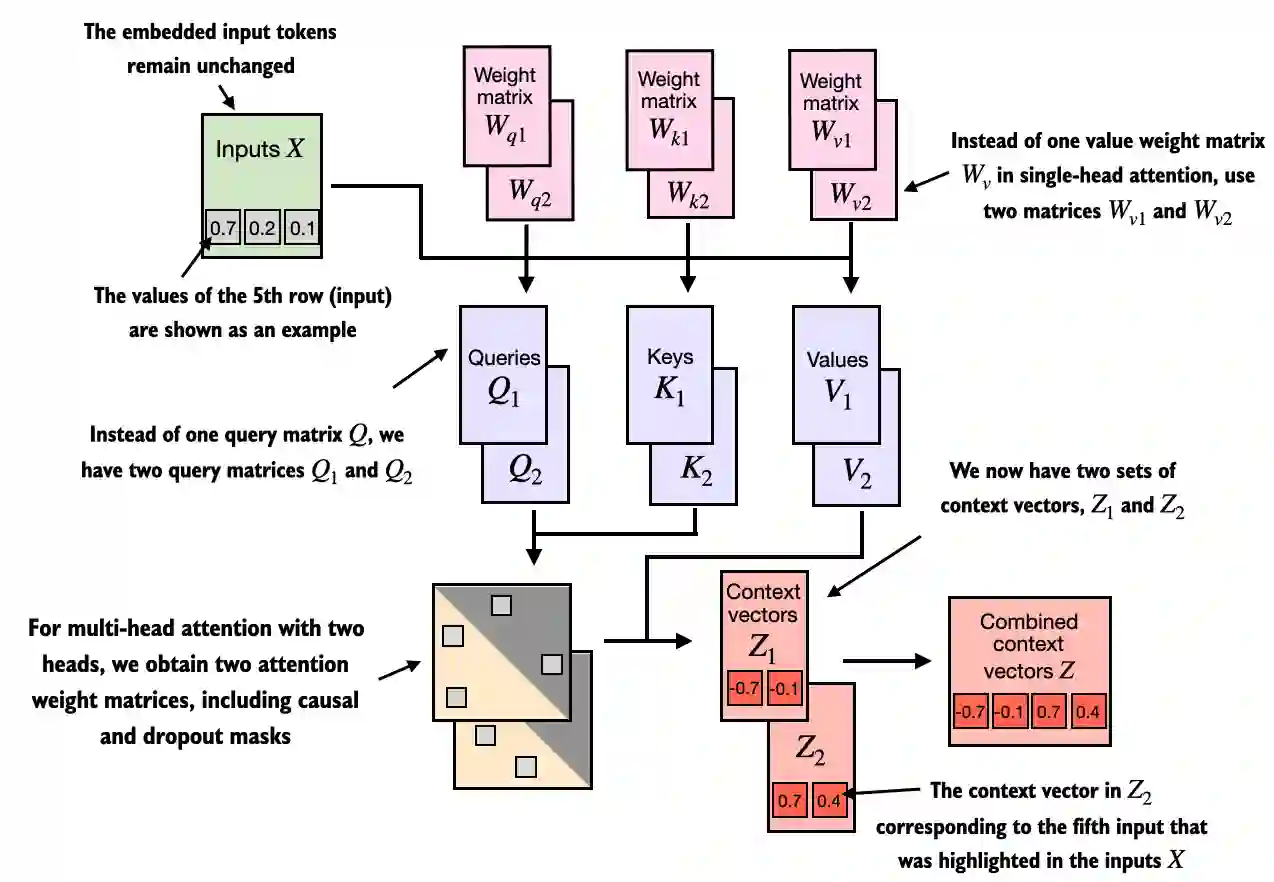

- We have multiple $W_Q, W_K, W_V$ matrices, doing H number of attention operations in parallel.

In [83]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, heads):
    super().__init__()
    self.heads = nn.ModuleList([SelfAttentionV4(d_in, d_out) for _ in range(heads)])

  def forward(self, x):
    return torch.cat([head(x) for head in self.heads], dim=-1)



X = torch.rand((2, 3, 4), requires_grad=True)
d_in = X.shape[2]
d_out = 2

self_attention = MultiHeadAttention(d_in, d_out, heads=3)



self_attended_input = self_attention(X)
self_attended_input.shape


torch.Size([2, 3, 6])

#### Multihead attention through weight splits

In [98]:
class SelfAttentionV5(nn.Module):
    def __init__(self, d_in, d_out, heads):
        super().__init__()

        md_out = d_out * heads

        self.W_Q = torch.randn((d_in, md_out))
        self.W_K = torch.randn((d_in, md_out))
        self.W_V = torch.randn((d_in, md_out))

        self.d_in = d_in
        self.d_out = d_out
        self.md_out = md_out
        self.heads = heads

    def forward(self, x):

        # shape of input is (BS, T, d_in)

        Q = torch.matmul(x, self.W_Q)
        Q = Q.reshape(Q.shape[0], self.heads, Q.shape[1], self.d_out)

        # shape of Q is (BS, heads, T, d_out)

        K = torch.matmul(x, self.W_K)
        K = K.reshape(K.shape[0], self.heads, K.shape[1], self.d_out)

        V = torch.matmul(x, self.W_V)
        V = V.reshape(V.shape[0], self.heads, V.shape[1], self.d_out)

        # shape of Q.T should be (BS, heads, T, T)


        sqrt_dk = torch.sqrt(torch.tensor(K.shape[-1]))

        self_attention_scores = Q @ torch.transpose(K, 1, 2) / sqrt_dk

        return None

        mask = torch.triu(torch.ones_like(self_attention_scores, dtype=bool), diagonal=1)
        self_attention_scores[mask] = -float('inf')
        self_attention_matrix = torch.softmax(self_attention_scores, dim=-1) #(n, T, T) matrix

        # check that all rows of self attention matrix sum to 1

        assert(torch.allclose(self_attention_matrix.sum(dim=-1), torch.ones_like(self_attention_matrix.sum(dim=-1))))

        # check that self attention matrix is lower triangular
        assert(torch.allclose(self_attention_matrix, torch.tril(self_attention_matrix, diagonal=1)))

        self_attention_matrix = nn.Dropout(p=0.5)(self_attention_matrix)

        self_attended_input = self_attention_matrix @ V # (n, T, d_out)

        return self_attended_input

X = torch.rand((5, 3, 4), requires_grad=True)
d_in = X.shape[2]
d_out = 2

self_attention = SelfAttentionV5(d_in, d_out, heads=7)



self_attended_input = self_attention(X)
self_attended_input.shape


torch.Size([5, 3, 4]) torch.Size([4, 14])
torch.Size([5, 3, 14])


AttributeError: 'NoneType' object has no attribute 'shape'